Required libraries for K-Nearest Neighbours

- pandas
- scikit-learn
- matplotlib
- seaborn

> Ensure required libraries are installed before running the notebook

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.inspection import permutation_importance

Load the dataset to be used

In [50]:
# Load dataset
train_df = pd.read_csv('train_data_with_traffic_class.csv')
test_df = pd.read_csv('test_data_with_traffic_class.csv')

PLACEHOLDER

In [51]:
# Define features (X) and target (y) for training dataset
X_train_features = train_df.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])
# Encode categorical variables with One-hot encoding
X_train_features = pd.get_dummies(X_train_features, columns=["Country"], drop_first=True)
y_train_labels = train_df["Traffic_Class"]

# Define features (X) and target (y) for test dataset
X_test_features = test_df.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])
# Encode categorical variables with One-hot encoding
X_test_features = pd.get_dummies(X_test_features, columns=["Country"], drop_first=True)
y_test_labels = test_df["Traffic_Class"]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train_labels, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_features)

PLACEHOLDER

In [52]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model on the training data
knn.fit(X_train_scaled, y_train)

# Validate the model on the validation set
y_val_pred = knn.predict(X_val_scaled)

# Evaluate model performance on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Balanced Accuracy: {balanced_acc:.4f}")

unique_classes = np.unique(y_val)
target_names = [str(cls) for cls in unique_classes]  # Convert to string if necessary

# Display classification report with precision, recall, f1-score, and support
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Validate the model on the test set
y_test_pred = knn.predict(X_test_scaled)

# Evaluate model performance on the test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

# Display classification report for the test set
print("\nTest Classification Report:")
print(classification_report(y_test_labels, y_test_pred, target_names=target_names))


Validation Accuracy: 0.8980
Validation Balanced Accuracy: 0.8809

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       330
           1       0.96      0.91      0.93      1092
           2       0.67      0.88      0.76        68

    accuracy                           0.90      1490
   macro avg       0.80      0.88      0.84      1490
weighted avg       0.90      0.90      0.90      1490

Test Accuracy: 0.7773
Test Balanced Accuracy: 0.7019

Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.56      0.71       177
           1       0.71      0.98      0.83       229
           2       0.86      0.56      0.68        43

    accuracy                           0.78       449
   macro avg       0.84      0.70      0.74       449
weighted avg       0.82      0.78      0.77       449



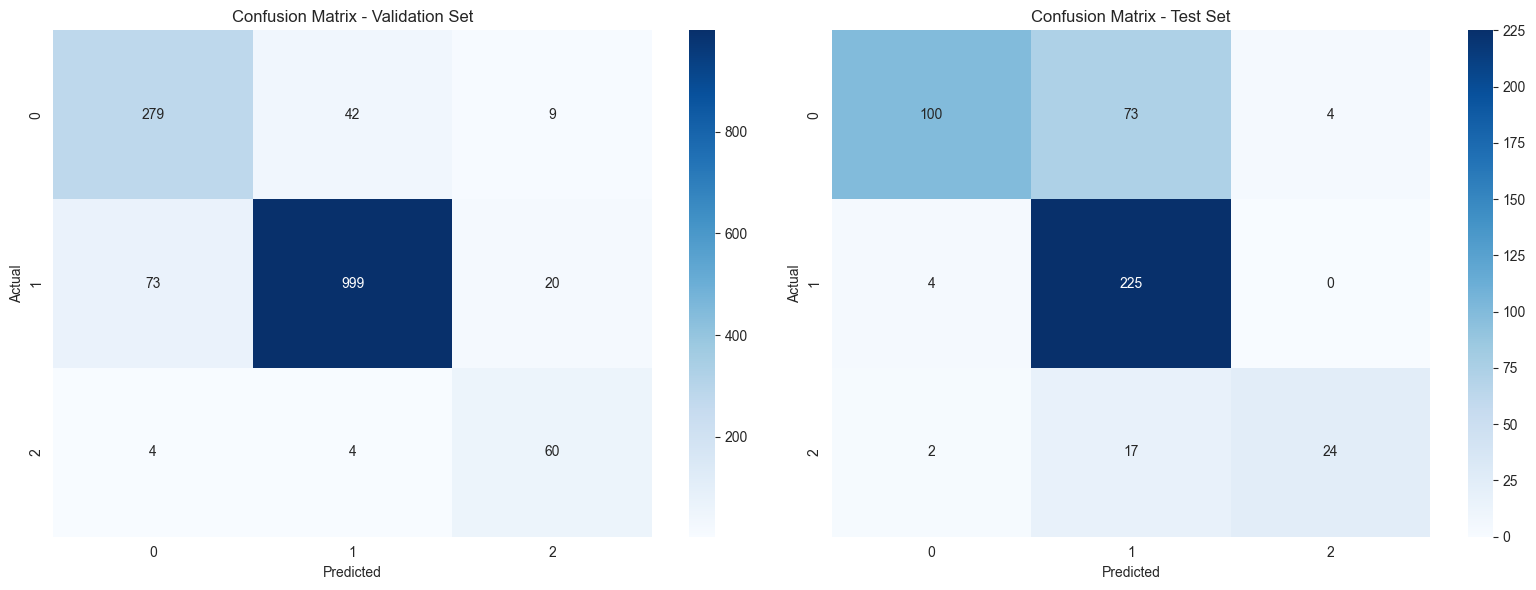

In [53]:
# Create confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test_labels, y_test_pred)

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot validation confusion matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Validation Set')

# Plot test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - Test Set')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


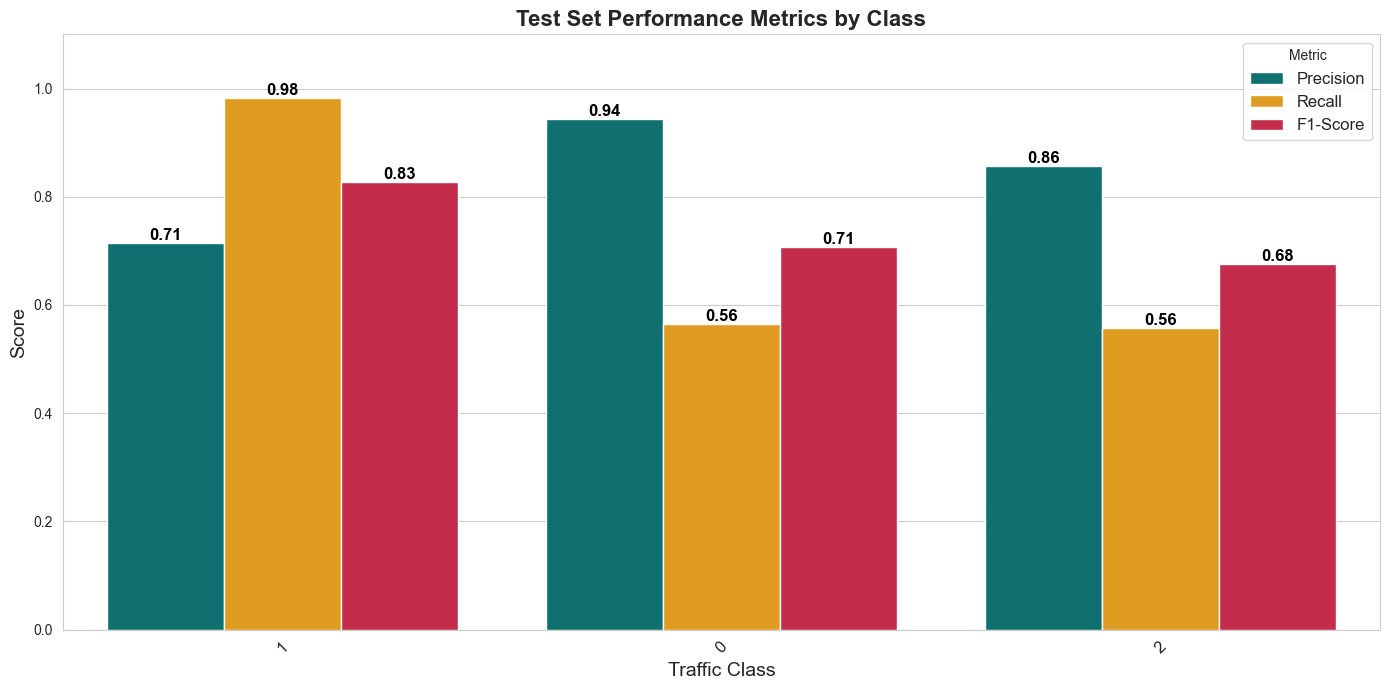

In [ ]:
# Calculate metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_test_pred)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
 
# Sort by F1-Score (descending) for better visualization
metrics_df = metrics_df.sort_values(by="F1-Score", ascending=False)

# Melt for easier plotting
metrics_melt = pd.melt(metrics_df, id_vars=['Class'], 
                      value_vars=['Precision', 'Recall', 'F1-Score'],
                      var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")  # Add a clean grid style
palette = {"Precision": "teal", "Recall": "orange", "F1-Score": "crimson"}  # Custom colors

ax = sns.barplot(data=metrics_melt, x='Class', y='Score', hue='Metric', palette=palette)

# Add value labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with height > 0
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Titles and labels
plt.title('Test Set Performance Metrics by Class', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.1)  # Slightly above 1 for better spacing
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()

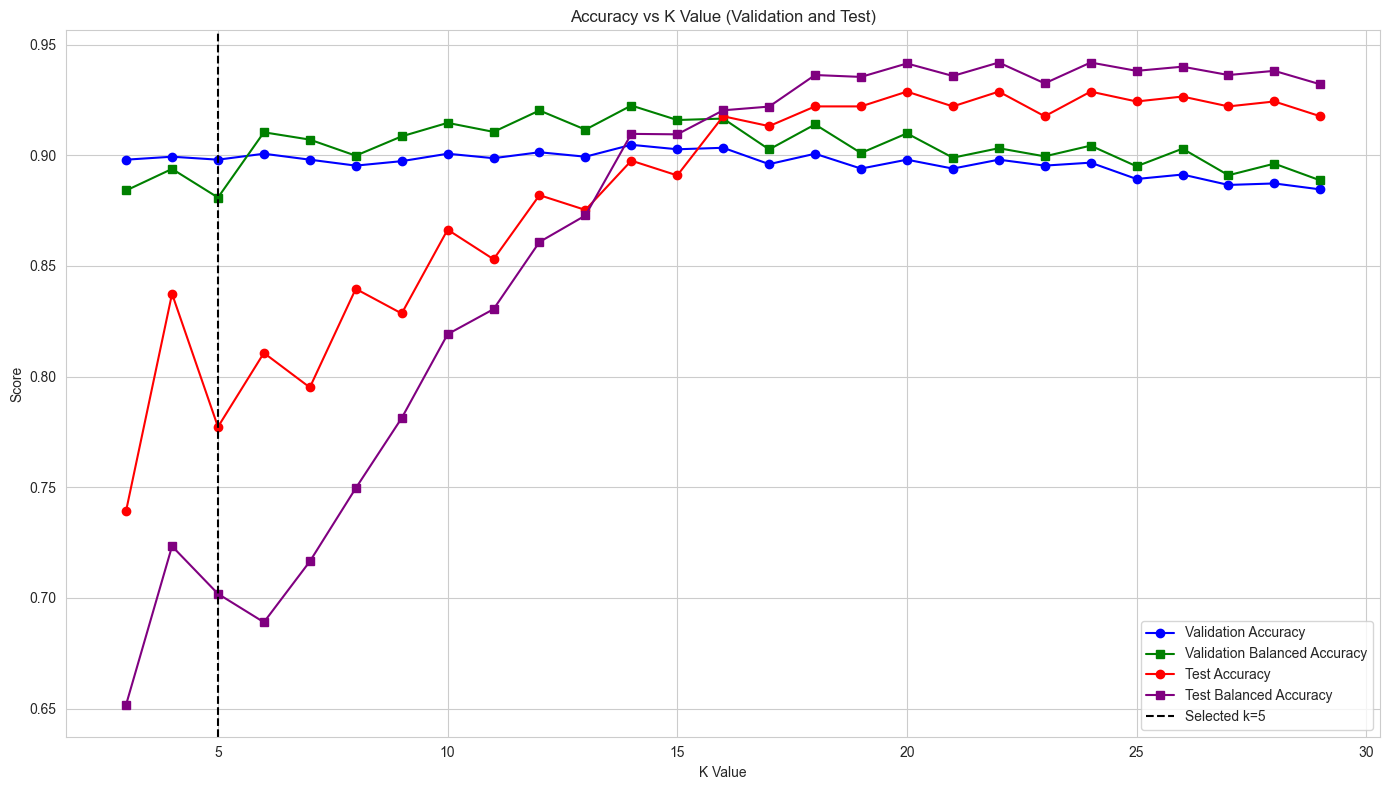

In [55]:
# Testing different K values for both validation and test sets
k_range = range(3, 30)
val_scores = []
val_balanced_scores = []
test_scores = []
test_balanced_scores = []

for k in k_range:
    knn_test = KNeighborsClassifier(n_neighbors=k)
    knn_test.fit(X_train_scaled, y_train)
    
    # Validation set predictions
    y_val_pred = knn_test.predict(X_val_scaled)
    val_scores.append(accuracy_score(y_val, y_val_pred))
    val_balanced_scores.append(balanced_accuracy_score(y_val, y_val_pred))
    
    # Test set predictions
    y_test_pred = knn_test.predict(X_test_scaled)
    test_scores.append(accuracy_score(y_test_labels, y_test_pred))
    test_balanced_scores.append(balanced_accuracy_score(y_test_labels, y_test_pred))

# Plot results
plt.figure(figsize=(14, 8))

# Plot validation set metrics
plt.plot(k_range, val_scores, 'o-', color='blue', label='Validation Accuracy')
plt.plot(k_range, val_balanced_scores, 's-', color='green', label='Validation Balanced Accuracy')

# Plot test set metrics
plt.plot(k_range, test_scores, 'o-', color='red', label='Test Accuracy')
plt.plot(k_range, test_balanced_scores, 's-', color='purple', label='Test Balanced Accuracy')

# Add vertical line for k=5
plt.axvline(x=5, color='black', linestyle='--', label='Selected k=5')

plt.xlabel('K Value')
plt.ylabel('Score')
plt.title('Accuracy vs K Value (Validation and Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

PLACEHOLDER

In [56]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': range(3, 21),  # Test values from 3 to 20
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Distance metric
}

PLACEHOLDER

In [ ]:
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(
    estimator=knn, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding accuracy
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

Best parameters found:  {'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best cross-validation accuracy:  0.9139568345323742


PLACEHOLDER

In [58]:
# Get the best model from GridSearchCV
best_knn = grid_search.best_estimator_

# Validate the best model on the validation set
y_val_pred = best_knn.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with Best Model: {val_accuracy:.4f}")
print(f"Validation Balanced Accuracy: {balanced_acc:.4f}")

# Display classification report for the validation set
unique_classes = np.unique(y_val)
target_names = [str(cls) for cls in unique_classes]  # Convert to string if necessary
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Test the best model on the test set
y_test_pred = best_knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy with Best Model: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

# Display classification report for the test set
print("\nTest Classification Report:")
print(classification_report(y_test_labels, y_test_pred, target_names=target_names))

Validation Accuracy with Best Model: 0.9107
Validation Balanced Accuracy: 0.9143

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       330
           1       0.96      0.93      0.94      1092
           2       0.76      0.97      0.85        68

    accuracy                           0.91      1490
   macro avg       0.84      0.91      0.87      1490
weighted avg       0.92      0.91      0.91      1490

Test Accuracy with Best Model: 0.7862
Test Balanced Accuracy: 0.7207

Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.71       177
           1       0.73      0.99      0.84       229
           2       0.87      0.60      0.71        43

    accuracy                           0.79       449
   macro avg       0.84      0.72      0.75       449
weighted avg       0.82      0.79      0.77       449



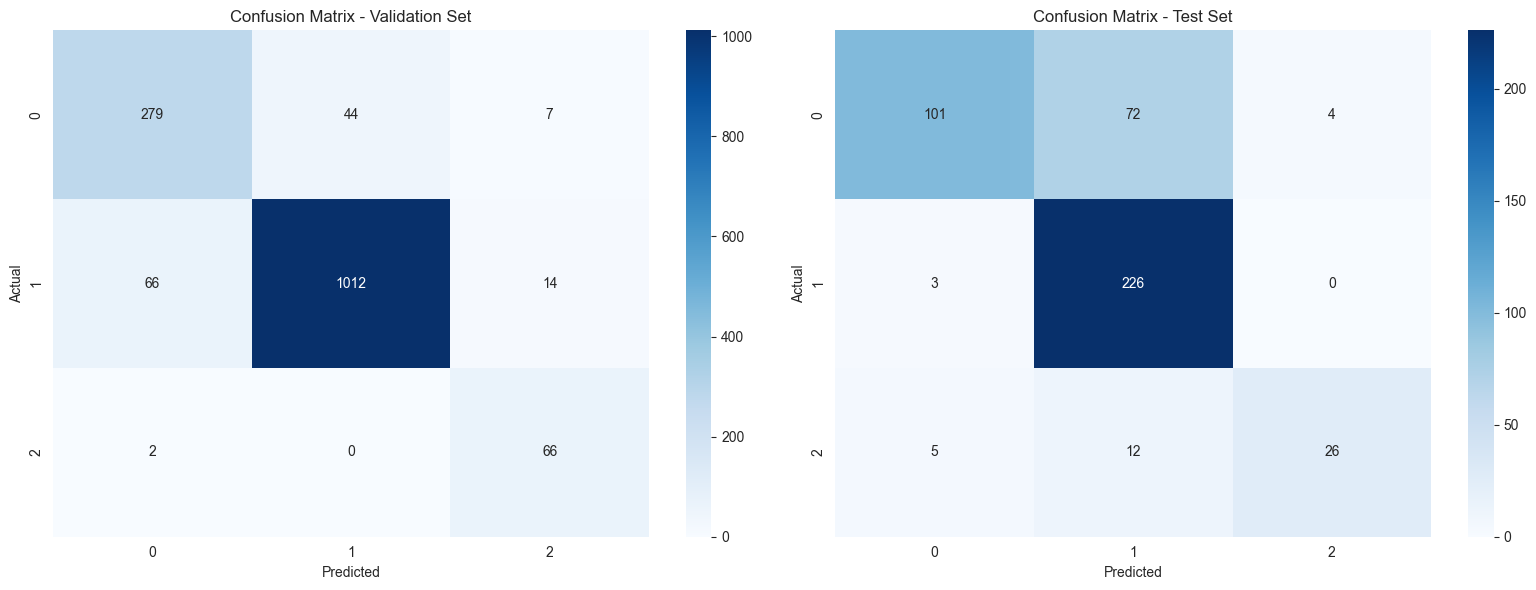

In [59]:
# Create confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test_labels, y_test_pred)

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Validation Set')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - Test Set')

plt.tight_layout()
plt.show()


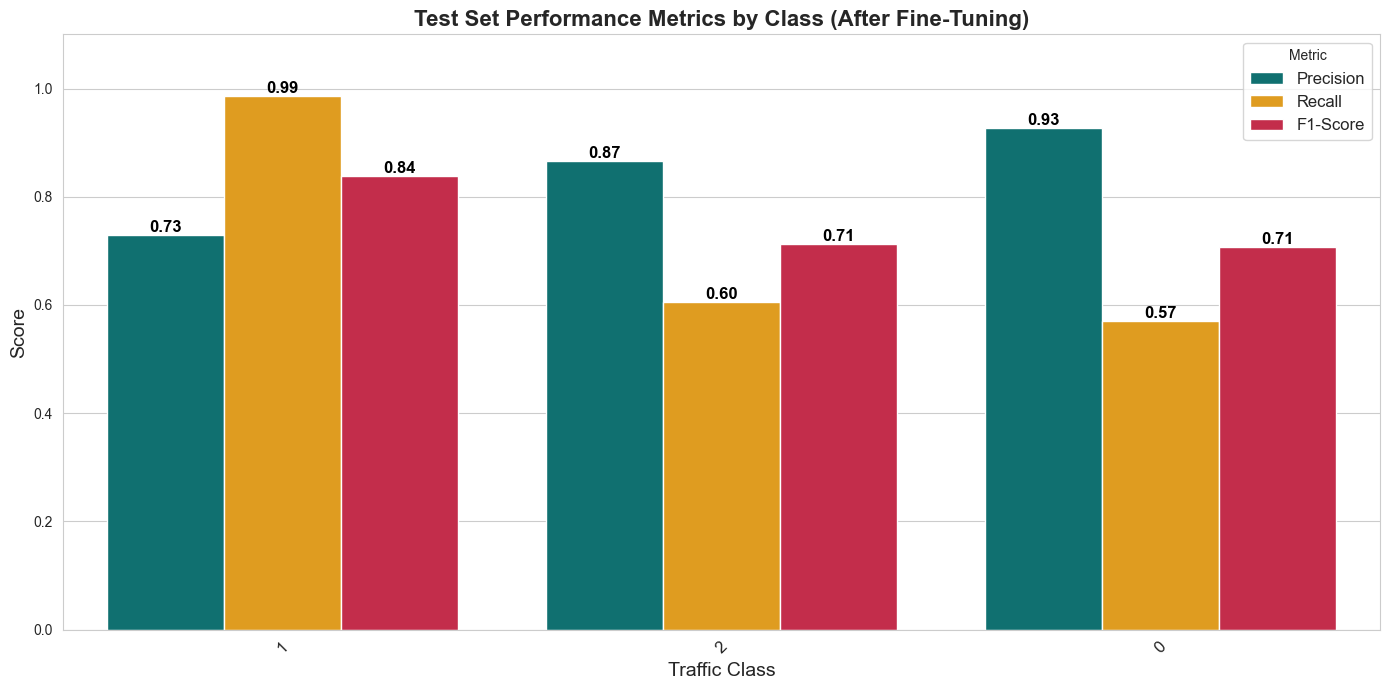

In [60]:
# Calculate metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_test_pred)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Sort by F1-Score (descending) for better visualization
metrics_df = metrics_df.sort_values(by="F1-Score", ascending=False)

# Melt for easier plotting
metrics_melt = pd.melt(metrics_df, id_vars=['Class'], 
                      value_vars=['Precision', 'Recall', 'F1-Score'],
                      var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")  # Add a clean grid style
palette = {"Precision": "teal", "Recall": "orange", "F1-Score": "crimson"}  # Custom colors

ax = sns.barplot(data=metrics_melt, x='Class', y='Score', hue='Metric', palette=palette)

# Add value labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with height > 0
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Titles and labels
plt.title('Test Set Performance Metrics by Class (After Fine-Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.1)  # Slightly above 1 for better spacing
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()


E:\Temp\ipykernel_1384\2159030062.py:14: FutureWarning: The provided callable <function mean at 0x00000136CBCF32E0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  n_w_pivot = pivot_results.pivot_table(
E:\Temp\ipykernel_1384\2159030062.py:24: FutureWarning: The provided callable <function mean at 0x00000136CBCF32E0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  p_m_pivot = pivot_results.pivot_table(


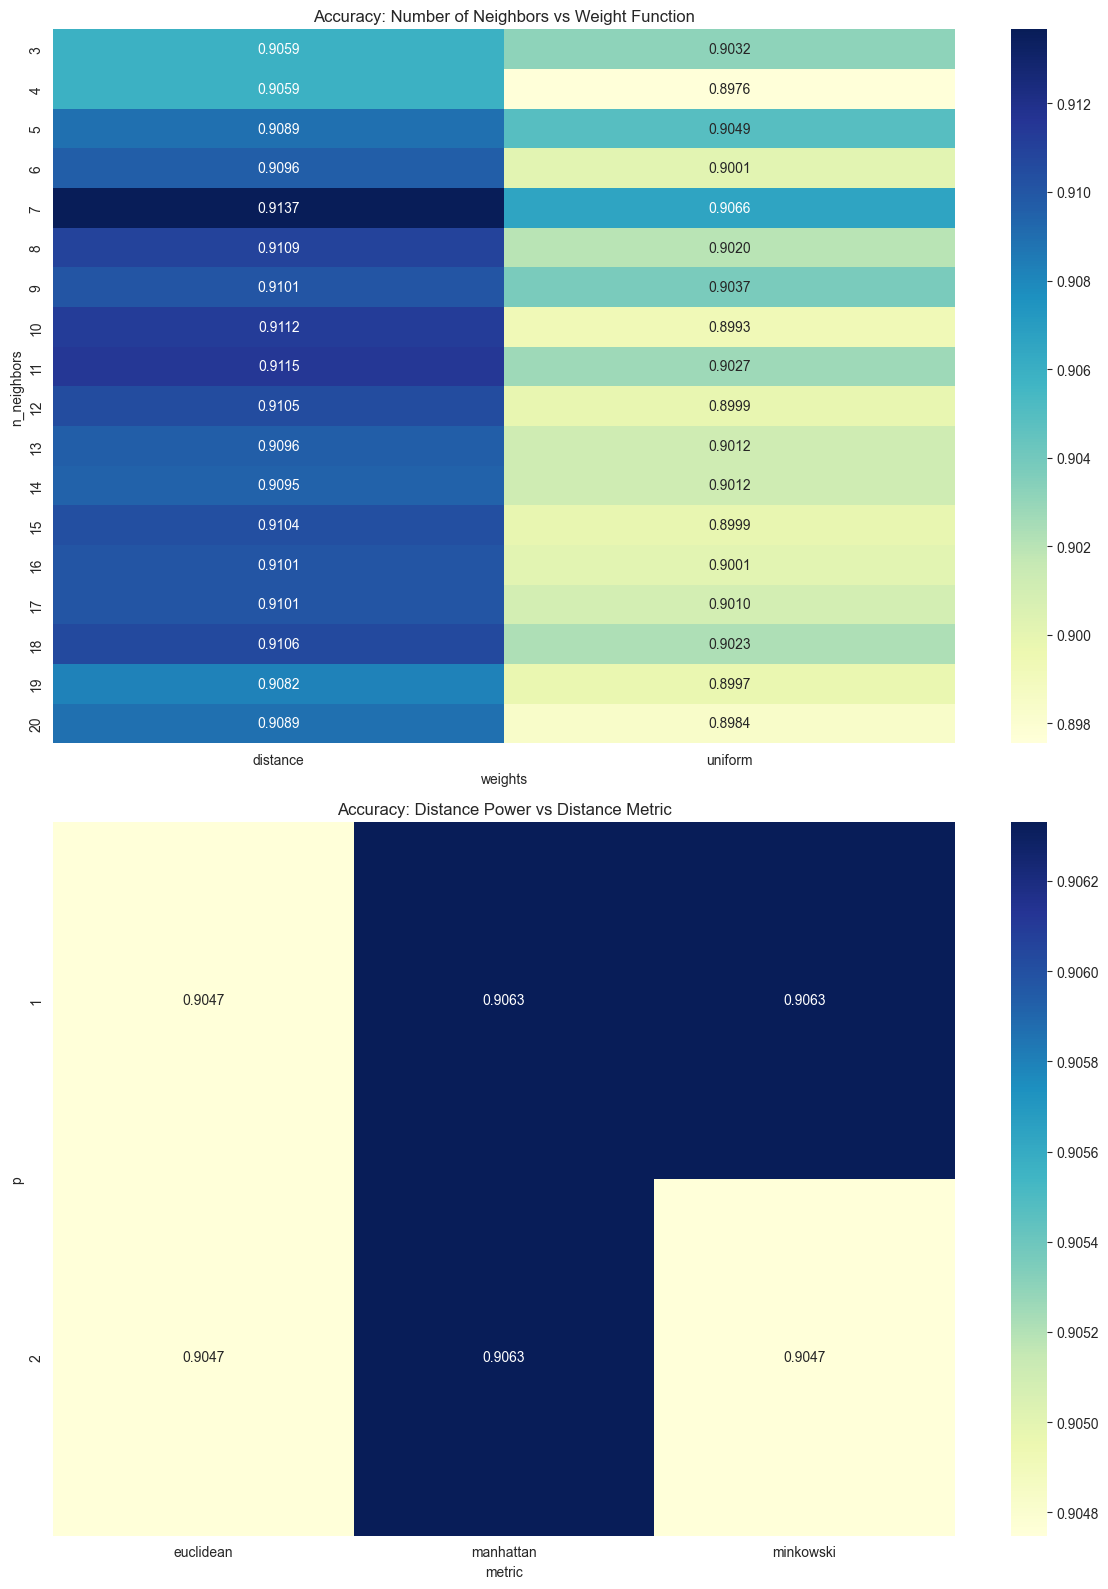

In [61]:
# Extract results from grid search
results = pd.DataFrame(grid_search.cv_results_)

# Create pivot table to visualize parameter combinations
pivot_results = pd.DataFrame()
for param in ['n_neighbors', 'weights', 'p', 'metric']:
    pivot_results[param] = [p[param] for p in results['params']]
pivot_results['accuracy'] = results['mean_test_score']

# Create multiple heat maps to show different parameter combinations
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# n_neighbors vs weights
n_w_pivot = pivot_results.pivot_table(
    values='accuracy', 
    index='n_neighbors',
    columns='weights',
    aggfunc=np.mean
)
sns.heatmap(n_w_pivot, annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[0])
axes[0].set_title('Accuracy: Number of Neighbors vs Weight Function')

# p (distance type) vs metric
p_m_pivot = pivot_results.pivot_table(
    values='accuracy', 
    index='p',
    columns='metric',
    aggfunc=np.mean
)
sns.heatmap(p_m_pivot, annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Accuracy: Distance Power vs Distance Metric')

plt.tight_layout()
plt.show()

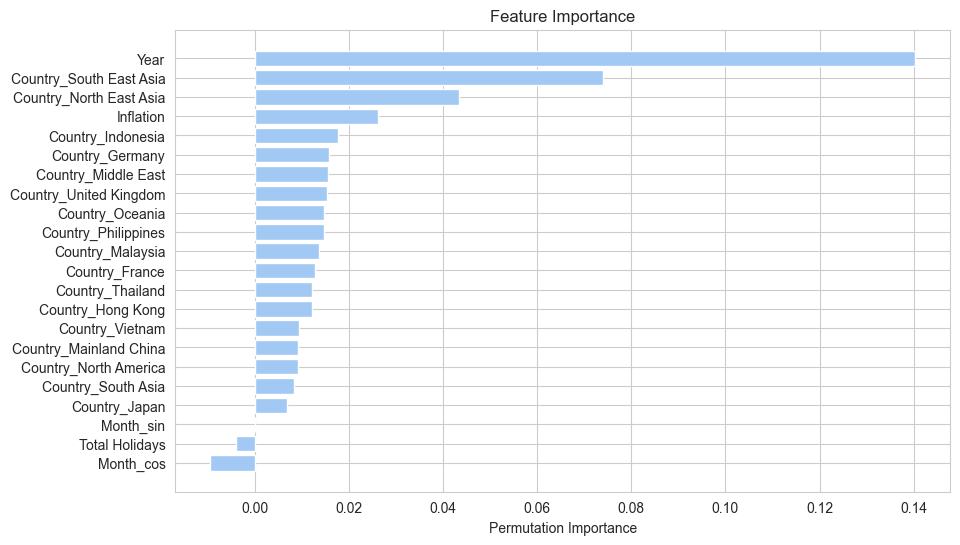

In [62]:
# Calculate permutation importance
result = permutation_importance(best_knn, X_val_scaled, y_val, n_repeats=10, random_state=42)

# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

E:\Temp\ipykernel_1384\1534996258.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(['Manhattan (p=1)', 'Euclidean (p=2)'])


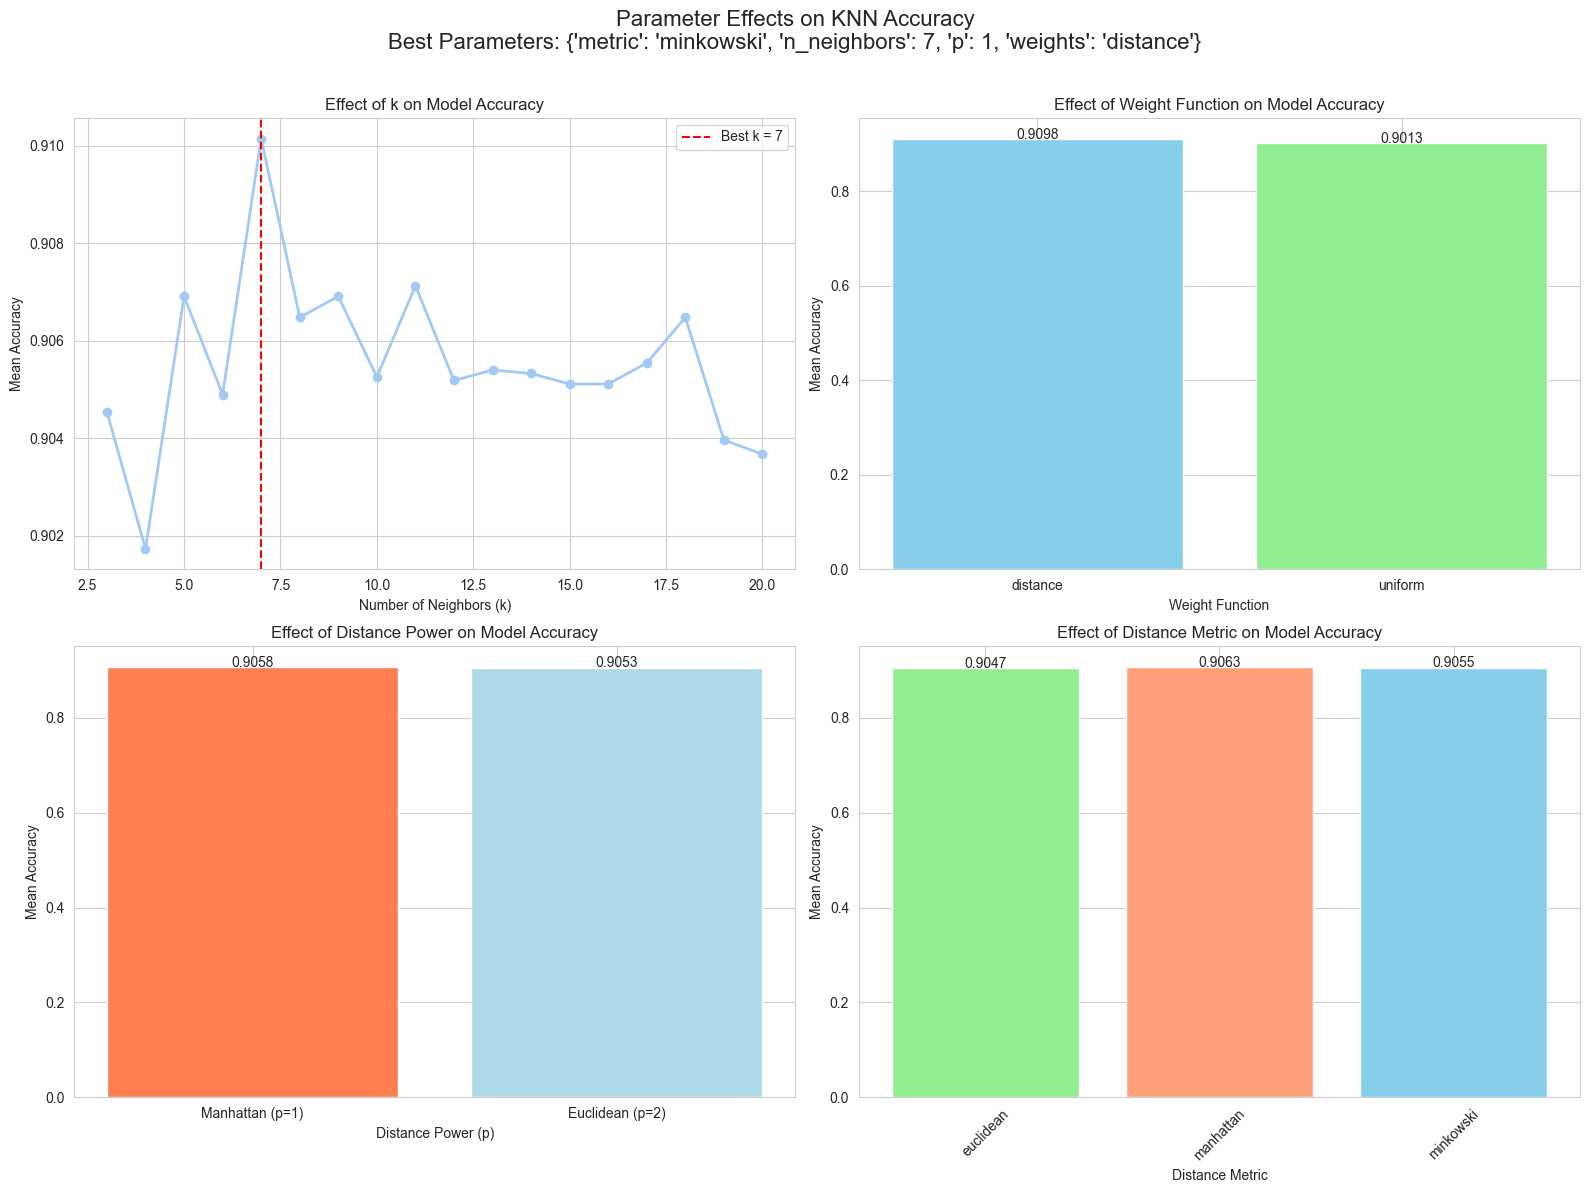

In [ ]:
# Extract results from grid search
results = pd.DataFrame(grid_search.cv_results_)

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot for n_neighbors
n_neighbors_df = results.groupby('param_n_neighbors')['mean_test_score'].mean().reset_index()
axs[0, 0].plot(n_neighbors_df['param_n_neighbors'], n_neighbors_df['mean_test_score'], 'o-', linewidth=2)
axs[0, 0].set_xlabel('Number of Neighbors (k)')
axs[0, 0].set_ylabel('Mean Accuracy')
axs[0, 0].set_title('Effect of k on Model Accuracy')
axs[0, 0].grid(True)
best_k = n_neighbors_df.loc[n_neighbors_df['mean_test_score'].idxmax(), 'param_n_neighbors']
axs[0, 0].axvline(x=best_k, color='r', linestyle='--', 
                 label=f'Best k = {best_k}')
axs[0, 0].legend()

# Plot for weights
weights_df = results.groupby('param_weights')['mean_test_score'].mean().reset_index()
axs[0, 1].bar(weights_df['param_weights'], weights_df['mean_test_score'], color=['skyblue', 'lightgreen'])
axs[0, 1].set_xlabel('Weight Function')
axs[0, 1].set_ylabel('Mean Accuracy')
axs[0, 1].set_title('Effect of Weight Function on Model Accuracy')
for i, v in enumerate(weights_df['mean_test_score']):
    axs[0, 1].text(i, v + 0.001, f"{v:.4f}", ha='center')
axs[0, 1].grid(True, axis='y')

# Plot for p (Manhattan vs. Euclidean)
p_df = results.groupby('param_p')['mean_test_score'].mean().reset_index()
axs[1, 0].bar(p_df['param_p'].astype(str), p_df['mean_test_score'], color=['coral', 'lightblue'])
axs[1, 0].set_xlabel('Distance Power (p)')
axs[1, 0].set_ylabel('Mean Accuracy')
axs[1, 0].set_title('Effect of Distance Power on Model Accuracy')
axs[1, 0].set_xticklabels(['Manhattan (p=1)', 'Euclidean (p=2)'])
for i, v in enumerate(p_df['mean_test_score']):
    axs[1, 0].text(i, v + 0.001, f"{v:.4f}", ha='center')
axs[1, 0].grid(True, axis='y')

# Plot for metric
metric_df = results.groupby('param_metric')['mean_test_score'].mean().reset_index()
axs[1, 1].bar(metric_df['param_metric'], metric_df['mean_test_score'], color=['lightgreen', 'lightsalmon', 'skyblue'])
axs[1, 1].set_xlabel('Distance Metric')
axs[1, 1].set_ylabel('Mean Accuracy')
axs[1, 1].set_title('Effect of Distance Metric on Model Accuracy')
axs[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(metric_df['mean_test_score']):
    axs[1, 1].text(i, v + 0.001, f"{v:.4f}", ha='center')
axs[1, 1].grid(True, axis='y')

# Add a title for the entire figure
fig.suptitle(f'Parameter Effects on KNN Accuracy\nBest Parameters: {grid_search.best_params_}', 
            fontsize=16, y=0.99)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()